In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision import models
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [78]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cpu
0.10.0+cpu


In [79]:
train_data_path = "../data/train/"
test_data_path = "../data/test/"

In [80]:
transforms = {"train":transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])]),
    "test":transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])
])}

In [81]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms["train"])
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms["test"])

In [82]:
print("Num Images in Train Dataset:", len(train_data))
print("Num Images in Test Dataset:", len(test_data))

Num Images in Train Dataset: 3416
Num Images in Test Dataset: 373


In [83]:
batch_size=16
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size,num_workers=8)

In [84]:
len(train_data)

3416

In [85]:
len(train_data.targets)

3416

In [86]:
batch = next(iter(train_data_loader))

In [87]:
images, labels = batch

In [88]:
images.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([13, 14, 15,  7,  2, 15, 15,  2,  8, 14,  2, 13, 15, 14,  8, 14])


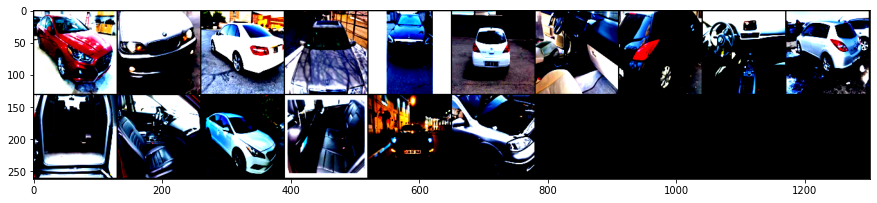

In [89]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels:", labels)

In [90]:
grid.shape

torch.Size([3, 262, 1302])

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*29*29, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=16)
#         self.act3 = nn.Softmax(dim=1)
    def forward(self, x):
        # (1) input layer
        x = x
        
        # (2) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        x = x.reshape(-1, 12*29*29)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        x = self.fc3(x)
#         x = F.softmax(x,dim=1)
        return x
network = Net()

In [92]:
sample = next(iter(train_data))

In [93]:
image,label = sample
print(label)
image.shape

0


torch.Size([3, 128, 128])

In [94]:
image.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [95]:
pred = network(image.unsqueeze(0))

In [96]:
pred.shape

torch.Size([1, 16])

In [97]:
pred.argmax(dim=1)

tensor([12])

In [98]:
batch = next(iter(train_data_loader))

In [99]:
images,labels = batch

**Calculating the loss**

In [100]:
preds = network(images)

In [101]:
loss = F.cross_entropy(preds,labels)
loss.item()

2.798152208328247

**Calculating gradients**

In [102]:
print(network.conv1.weight)

Parameter containing:
tensor([[[[ 0.0160,  0.0967, -0.0545, -0.0141, -0.0376],
          [-0.0985,  0.0851, -0.0554,  0.0308,  0.0306],
          [-0.1148, -0.0485, -0.0250, -0.0685, -0.0006],
          [ 0.0746,  0.0607, -0.0770,  0.1100,  0.0881],
          [-0.0396, -0.0440, -0.0543, -0.0617, -0.0018]],

         [[ 0.0359, -0.0985,  0.0655,  0.0190, -0.0830],
          [ 0.0440, -0.0215,  0.1111,  0.0205,  0.0674],
          [ 0.0087, -0.0521,  0.0211, -0.0905, -0.1047],
          [ 0.0320,  0.0587, -0.1107, -0.0268,  0.0385],
          [ 0.1083,  0.0402, -0.0552,  0.0184, -0.0421]],

         [[-0.0332, -0.0859,  0.0590,  0.0805, -0.0342],
          [-0.1125,  0.0515, -0.0760, -0.0179,  0.0221],
          [-0.1142, -0.0864,  0.0166,  0.0201,  0.0642],
          [ 0.0166, -0.0774, -0.0042, -0.0075,  0.0083],
          [ 0.0348,  0.0653,  0.0056,  0.0075,  0.0974]]],


        [[[-0.0922,  0.0092, -0.0232, -0.0407,  0.0986],
          [-0.1107,  0.0122, -0.0471, -0.0731, -0.0640],
 

In [103]:
loss.backward()  # Calculating gradients

In [104]:
network.conv1.weight.grad.shape

torch.Size([6, 3, 5, 5])

**Updating the Weights**

In [105]:
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [106]:
loss.item()

2.798152208328247

**TensorBoard**

In [107]:
# tb = SummaryWriter()

# network = Net()
# images, labels = next(iter(train_data_loader))
# grid = torchvision.utils.make_grid(images)

# tb.add_image('images', grid)
# tb.add_graph(network,images)
# tb.close()


**train the model**

In [108]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [109]:

for epoch in range(1,25):
    total_loss = 0
    total_correct = 0
    for batch in train_data_loader:
        images,labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds,labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        total_correct+=get_num_correct(preds, labels)
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)


epoch: 1 total_correct: 1233 loss: 401.9829213619232
epoch: 2 total_correct: 1394 loss: 365.17354971170425
epoch: 3 total_correct: 1550 loss: 333.14489632844925
epoch: 4 total_correct: 1759 loss: 290.53908801078796
epoch: 5 total_correct: 2177 loss: 227.32060647010803
epoch: 6 total_correct: 2599 loss: 152.0340492874384
epoch: 7 total_correct: 2959 loss: 85.34415211901069
epoch: 8 total_correct: 3163 loss: 48.4195774467662
epoch: 9 total_correct: 3294 loss: 25.41662538284436
epoch: 10 total_correct: 3364 loss: 10.686375408899039
epoch: 11 total_correct: 3382 loss: 8.428501882881392
epoch: 12 total_correct: 3346 loss: 15.35319346410688
epoch: 13 total_correct: 3286 loss: 27.59242814523168
epoch: 14 total_correct: 3379 loss: 8.469255753530888
epoch: 15 total_correct: 3379 loss: 8.262164259562269
epoch: 16 total_correct: 3388 loss: 6.2383634317229735
epoch: 17 total_correct: 3387 loss: 5.824954586845706
epoch: 18 total_correct: 3358 loss: 11.340204950771295
epoch: 19 total_correct: 3335 l

In [110]:
get_num_correct(preds,labels)

8

In [111]:
preds = network(images)
loss = F.cross_entropy(preds,labels)

In [112]:
loss.item()

0.001074435655027628

In [113]:
get_num_correct(preds,labels)

8

In [114]:
preds.shape

torch.Size([8, 16])

In [115]:
preds

tensor([[  -7.3332,  -11.7102,   -3.5469,   -3.3257,  -14.4961,   -1.7992,
           -6.5278,   -6.1803,   -4.6405,   -9.0845,  -12.8641,   -5.1137,
          -12.4441,   -6.5170,   -4.5797,   10.2173],
        [  11.2311,  -20.0372,    1.5698,    1.8804,   -8.2585,  -17.0700,
          -14.0034,   -1.0649,   -4.9610,  -15.3324,  -23.6184,  -24.0191,
          -29.7873,  -21.2846,   -7.4343,  -16.2329],
        [ -40.2938,  -41.8154,    1.6828,  -44.9244,  -12.3961,    3.3696,
          -49.0314,  -24.5879,  -15.9144,  -32.4859,   -5.8711,  -20.9666,
          -25.9558,   19.6903,  -22.3014,  -10.5393],
        [ -10.4964,  -16.2402,   -0.2414,   -8.2002,  -10.8987,   -1.8717,
          -12.9289,   -5.4353,    7.9390,   -8.0290,  -17.0261,   -7.3352,
          -12.7970,   -9.2618,   -6.0286,    1.5567],
        [  -6.3243,   -5.4116,   -1.4508,   -3.5208,   -6.7154,   -2.2123,
           -1.8671,   -3.4298,   -3.0782,   -4.7468,   -6.3521,   -2.2209,
           -3.2541,   -3.7341,   -

In [116]:
preds.argmax(dim=1)

tensor([15,  0, 13,  8, 15, 14, 13, 14])

In [117]:
preds.argmax(dim=1).eq(labels)

tensor([True, True, True, True, True, True, True, True])

In [118]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [119]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = np.argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [120]:
# evaluate the model
acc = evaluate_model(test_data_loader, network)
print('Accuracy: %.3f' % acc)

Accuracy: 0.408
